In [13]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [14]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import seaborn as sns 
from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [16]:
from scipy.stats import kendalltau as kt
import numpy as np
import scipy.spatial.distance


In [17]:
from master_analysis import *

In [20]:
exps = pd.read_hdf(r'/home/nataliam/swdb_2017_tools/projects/mouseRSA/exps_w_RSA_wrunning.h5',mode='r')

In [21]:
exps.loc[(exps.imaging_depth>100) & (exps.imaging_depth<=200),'imaging_depth']=175

exps.loc[(exps.imaging_depth>300) & (exps.imaging_depth<500),'imaging_depth']=350
exps.loc[(exps.imaging_depth>200) & (exps.imaging_depth<=300),'imaging_depth']=275
exps.loc[(exps.cre_line=='Nr5a1-Cre'),'imaging_depth']=275

In [57]:
def get_rfs(exps):
    rfs = []
    for exp_id in exps.id.values:
    
        try:
            rf = get_population_rf(boc, exp_id)
        except: 
            rf = np.array([np.nan, np.nan])
        rfs.append(rf)
    return rfs

In [58]:
rfs = get_rfs(exps_wrunning)

In [140]:
def get_valid_cluster(rfs, exps, center):
    """Returns a boolean array of length exps for this cluster. 
    exps = experiment dataframe
    rfs = list of rf arrays
    center = length 2. position."""
    # First get RF center of masses
    coms = []
    for rf in rfs:
        
        
        if rf.shape== (8,14):
                # 8 deg sparse noise
            com = np.array(center_of_mass(rf))*9.3 # to degrees
        elif rf.shape== (2,):
            com = np.array([np.nan, np.nan])
        else:
            com = np.array(center_of_mass(rf))*4.6 # to degrees


        coms.append(com)
        
    # now get distances to center
    center = np.array(center)
    dists = np.linalg.norm(np.array(coms)-center,axis=1)

    areas = exps.targeted_structure
    area_stds = {}
    # get average standard deviations: RMS distance from centroid
    for area in areas.unique():
        this_std = []
        # loop through all exps
        for i,rf in enumerate(rfs):
            if area != areas[i]: 
                continue
            if rf.shape== (2,): 
                this_std.append(np.nan)
            else:
                this_std.append(get_weighted_stdev(rf, coms[i]))
        area_stds[area] = np.nanmean(this_std)
        
    # create boolean array. True if < area's stdev
    valids = []
    for i in range(len(dists)):
        if dists[i] < area_stds[areas[i]]/2:
            valids.append(True)
        else: valids.append(False)
    
        
    return valids

In [141]:
def get_weighted_stdev(rf,com):
    factor = 9.3 if rf.shape== (8,14) else 4.6
    
    #first get distances
    ds =[]
    ws = []
    
    # normalize rf to 1
    rf = rf/rf.mean()
    
    for i in range(rf.shape[0]):
        for j in range(rf.shape[1]):
            ds.append(np.linalg.norm([i*factor-com[0],j*factor-com[1]]))
            ws.append(rf[i,j])
            
    std = np.std( np.array(ds) * np.array(ws) )
    
    return std

In [147]:
cluster1 = get_valid_cluster(rfs,exps_wrunning, np.array([43,27]))
cluster2 = get_valid_cluster(rfs,exps_wrunning, np.array([35,45]))
cluster3 = get_valid_cluster(rfs,exps_wrunning, np.array([27,57]))


/opt/conda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


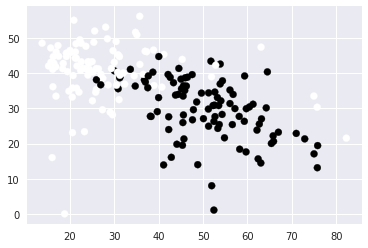

In [150]:
plt.scatter(coms[1],coms[0],c=cluster3)

In [151]:
clusters = pd.DataFrame([cluster1, cluster2, cluster3])

In [154]:
clusters.to_hdf('final_cluster_bools.h5',key='clusters')

In [61]:
rf_df = pd.DataFrame(rfs)
rf_df.to_hdf('RFs.h5','rf_df', mode='w')

/opt/conda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:1138: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->[0]]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


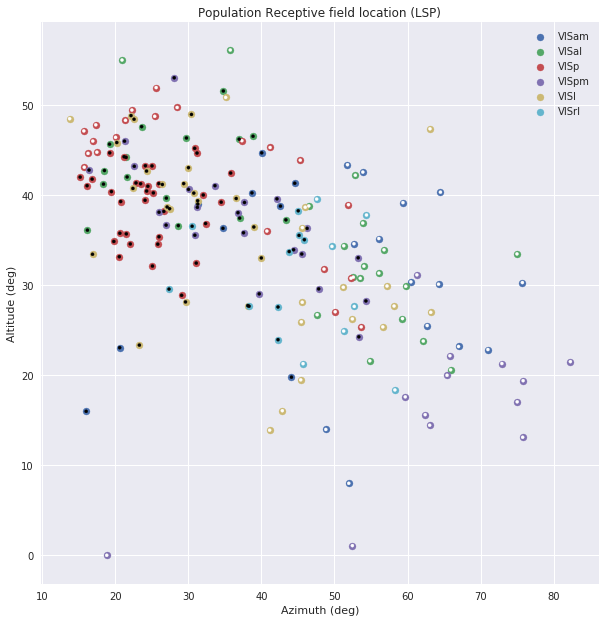

In [144]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = exps.targeted_structure[:len(coms)]
y,x = np.array(coms[0]),np.array(coms[1])

for area in areas.unique():
    plt.scatter(
        x[(areas==area).values], y[(areas==area).values], marker = 'o'
        )

plt.legend(areas.unique())
plt.scatter(coms[1],coms[0],c=cluster1,s=10)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
plt.xticks()
plt.title('Population Receptive field location (LSP)')

In [153]:
np.array(center_of_mass(rf))*8

array([ 43.41377733,  51.77926139])

In [254]:
# within area RSM comparisons 

In [255]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_cre_lines()
targeted_structures=boc.get_all_targeted_structures()
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [262]:
exps_grouped=get_experiments_grouped(exps_wrunning,targeted_structures,cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = cluster1,
                                     rsm_selection='mean')


In [263]:
kt_all = get_all_kt_matrix(exps_grouped)
kt_all = kt_all.sort_index(axis=0).sort_index(axis=1)


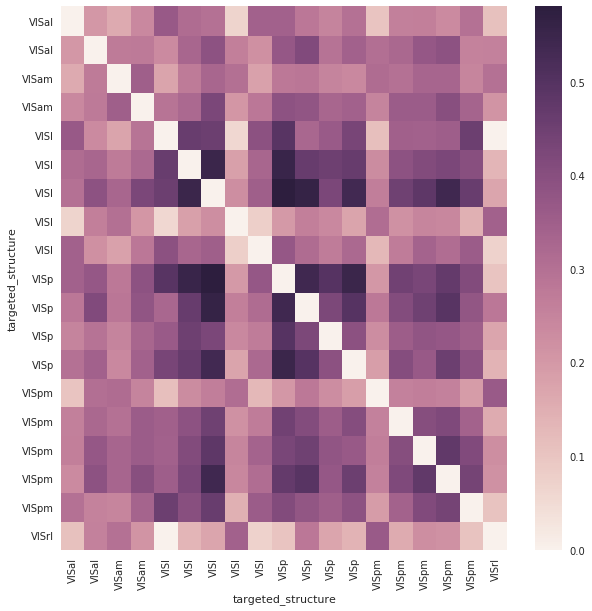

In [264]:
plt.figure(figsize=(10,10))
sns.heatmap(kt_all,vmin=0)


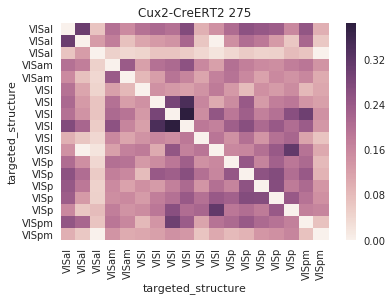

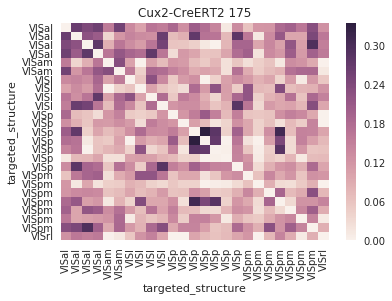

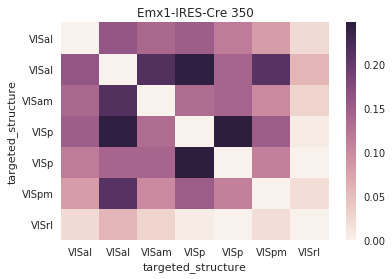

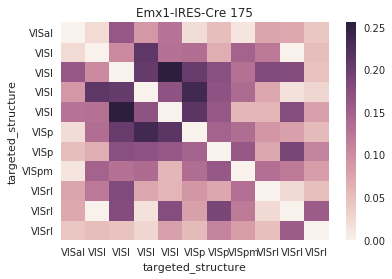

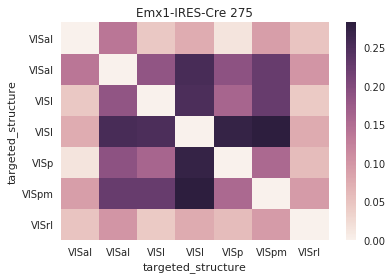

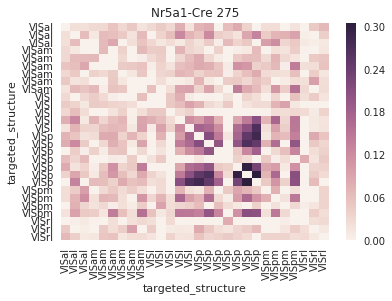

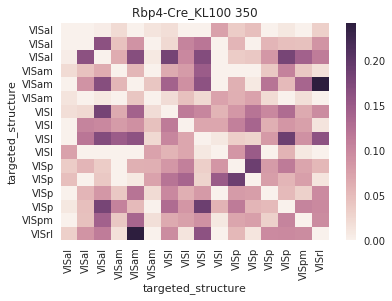

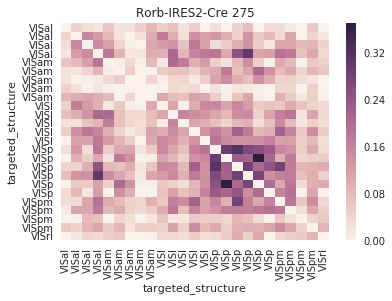

In [224]:
kt_dfs=get_kt_matrix(just_nonzeros,'targeted_structure')

In [ ]:
# to do: modify get_experiments_grouped so that it takes into account the valid_stimuli columns

In [ ]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA

In [ ]:
def get_unfolded_rsm(exps_grouped):
    """Takes the result of get_experiments_grouped and performs a 2D embedding on the rsms.
    Output: 2D numpy array of length number_experiments"""
    n_stim = exps_grouped.loc[0,'rsm'].shape[0]
    matrix_to_embed = np.vstack(
                        exps_grouped.rsm.apply( # apply this function to each rsm
                                scipy.spatial.distance.squareform))
        
    return matrix_to_embed

In [ ]:
def scatter_viz(to_plot,exps_grouped):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.subplots_adjust(bottom = 0.1)

    areas = exps_grouped.targeted_structure
    
    for area in areas.unique():

        plt.scatter(
            to_plot[areas.values==area, 0], to_plot[areas.values==area, 1], marker = 'o'
            )

    plt.legend(areas.unique())

In [ ]:
to_embed = get_unfolded_rsm(exps_grouped)

Reduce dimensions with PCA then run tsne

In [ ]:
se = SpectralEmbedding(n_components = 10)
se_rsm = se.fit_transform(to_embed)

In [ ]:
tsne = TSNE(perplexity=5.0,metric=)
to_plot = tsne.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = LocallyLinearEmbedding(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = SpectralEmbedding(n_components=3)
to_plot = method.fit_transform(to_embed)

pca = PCA(n_components=2, whiten=False)
to_plot = pca.fit_transform(to_plot)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = PCA(n_components=2)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

In [ ]:
method = MDS(n_components=2,eps = 1e-1)
to_plot = method.fit_transform(to_embed)
scatter_viz(to_plot, exps_grouped)

Or let's try to visualize the kts with MDS

In [184]:
kt_df = kt_dfs[-1]
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_df.values)
to_plot = results.embedding_

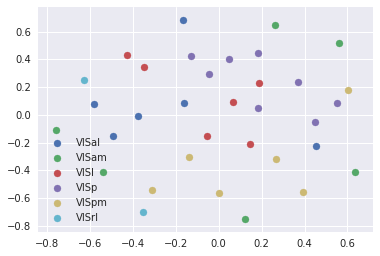

In [440]:

plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_df.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [441]:

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(1-kt_all.values)
to_plot = results.embedding_

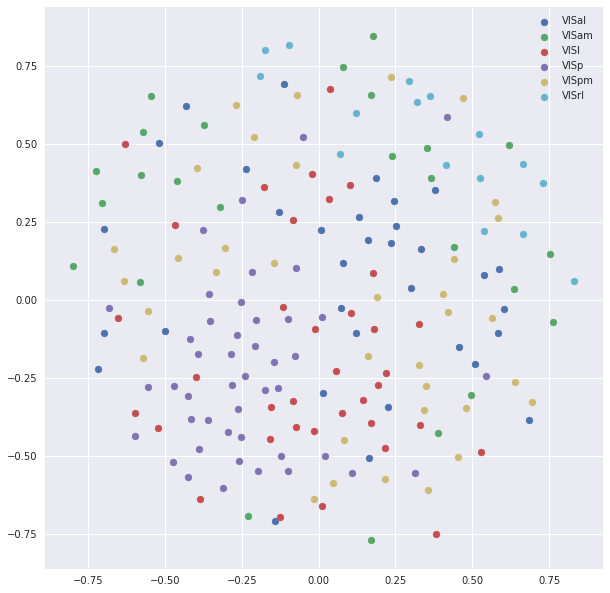

In [445]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_all.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [446]:
exps_grouped.head()

,cre_line,imaging_depth,targeted_structure,rsm
0,Cux2-CreERT2,275,VISal,"[[0.0, 14.0271879134, 17.7364615024, 17.471313..."
1,Cux2-CreERT2,275,VISal,"[[0.0, 19.7863268783, 24.5694978749, 20.453725..."
2,Cux2-CreERT2,275,VISal,"[[0.0, 10.065717023, 10.2442107709, 10.3606364..."
3,Cux2-CreERT2,275,VISal,"[[0.0, 19.5142452541, 20.1135017267, 20.266742..."
4,Cux2-CreERT2,275,VISal,"[[0.0, 12.7419734687, 12.0693315323, 11.451070..."


In [ ]:
exps_grouped['targeted_structure'].unique()

In [ ]:
available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
available_targeted_structures

In [ ]:
for cre_line in cre_lines
sns.heatmap(kt_df)
plt.title(cre_lines+imaging_depths)

In [ ]:
np.fill_diagonal(kt_matrix,0)
sns.heatmap(kt_matrix)

In [ ]:
rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsm.mean()

In [ ]:
to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])

In [ ]:
exps_grouped=exps_grouped.append(to_add.T)

In [ ]:
exps_grouped.head()